<a href="https://colab.research.google.com/github/meyresearch/ANI-Peptides/blob/main/demos/ANI2x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runtime Environment Setup

Allow kernel to restart after running this cell.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:40
🔁 Restarting kernel...


Ensure good conda/mamba installation

In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Install Dependencies - This takes a little while

*   **OpenMM**

 Base molecular simulation toolkit

*   **TorchANI**

 Implementation of ANI

*   **PyTorch**

 TorchANI runs on the PyTorch machine learning framework 

*   **OpenMM-Torch**

 A plugin for OpenMM that allows PyTorch static computation graphs (TorchANI) to be used in OpenMM as a TorchForce object, an OpenMM Force class 

*   **OpenMM-ML**

 Implements TorchANI as an OpenMM TorchForce using OpenMM-Torch. The glue that brings everything together!

*   **NGLview**

 3D molecule viewer

*   **PyTraj**

 Trajectory library

In [2]:
# seems to be some bug in pytorch, need to try to find a combination of dependencies that works.
# no difference using conda

!mamba install -q openmm openmm-torch pytorch torchani nglview
!pip install -q pytraj
!git clone https://github.com/openmm/openmm-ml
!pip install openmm-ml/.

  Package                          Version  Build                       Channel                    Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────

  argcomplete                       1.12.3  pyhd8ed1ab_2                conda-forge/noarch        34 KB
  argon2-cffi                       21.1.0  py37h5e8e339_2              conda-forge/linux-64      46 KB
  async_generator                     1.10  py_0                        conda-forge/noarch        18 KB
  attrs                             21.2.0  pyhd8ed1ab_0                conda-forge/noarch        44 KB
  backcall                           0.2.0  pyh9f0ad1d_0                conda-forge/noarch        13 KB
  backports                            1.0  py_2                        conda-forge/noarch         4 KB
  backports.functools_lru_cache      1.6.4  pyhd

Test OpenMM

In [13]:
!python -m openmm.testInstallation


OpenMM Version: 7.7
Git Revision: 130124a3f9277b054ec40927360a6ad20c8f5fa6

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.2902e-06
Reference vs. CUDA: 6.73547e-06
CPU vs. CUDA: 7.30642e-07
Reference vs. OpenCL: 1  *** LARGE DIFFERENCE **
CPU vs. OpenCL: 1  *** LARGE DIFFERENCE **
CUDA vs. OpenCL: 1  *** LARGE DIFFERENCE **
Problem with OpenMM installation encountered. OpenMM will not work correctly until the problem has been fixed.


Error message: Large differences observed. See messages above.


<openmm.openmm.Platform; proxy of <Swig Object of type 'OpenMM::Platform *' at 0x7fb15c959d80> >


Fetch sample peptide

In [5]:
!wget -q https://github.com/meyresearch/ANI-Peptides/raw/main/demos/aaa.pdb

# ANI Simulation

ANI2x cannot simulate Na or Cl in solvent. We create a mixed system where our protein is simulated by ANI, and the solvent by AMBER.

In [2]:
# Import libraries
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmmml import MLPotential

In [8]:
# Progress bar for simulations

from IPython.display import ProgressBar

class ProgressBarWriter(ProgressBar):
    def write(self, string):
        if string.startswith("#"):
            self.progress = 0
        else:
            string = string.strip(',\n')
            try:
                self.progress = int(string)
            except ValueError:
                pass

def ProgressBarReporter(steps, interval):
    return StateDataReporter(
        ProgressBarWriter(total = steps), 
        interval, 
        step = True,
        totalSteps = steps,
    )

In [4]:
# Simulation function (to run simulations consistently)

def simulate(
    simulation,
    output_pdb_filename: str = "output.pdb",
    output_state_data_filename: str = "state_data.csv",
    step_size: Quantity = 0.004*femtoseconds,
    steps: int or None = 100000,
    duration: Quantity or None = None,
    pdb_report_interval: int or None = None,
    state_report_interval: int or None = None,
    progressbar_interval: int or None = None,
):
    assert duration or steps

    if duration:
        steps = int(duration / step_size)

    if not pdb_report_interval:
        pdb_report_interval = steps // 10

    if not state_report_interval:
        state_report_interval = steps // 10

    if not progressbar_interval:
        progressbar_interval = steps // 50

    # Create pdb file reporter
    simulation.reporters.append(
        PDBReporter(
            output_pdb_filename,
            pdb_report_interval
        )
    )

    # Create state data file reporter
    simulation.reporters.append(
        StateDataReporter(
            output_state_data_filename, 
            state_report_interval, 
            step=True,
            potentialEnergy=True, 
            temperature=True
        )
    )

    # Create progress bar reporter
    simulation.reporters.append(
        ProgressBarReporter(steps, progressbar_interval)
    )

    # Run simulation through specified time steps
    print("Running simulation...")
    simulation.step(steps)

In [2]:
# Import libraries
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmmml import MLPotential
# Load sample peptide
pdb = PDBFile('aaa.pdb')
ml_atoms  = [atom.index for atom in pdb.topology.atoms() if atom.residue.name == "ALA"]

In [12]:
# Equilibration function - Constant pressure & temp

def equilibrate(
    coords: Topology,
    forcefield: ForceField,
    pressure: Quantity = 1*atmosphere,
    temperature: Quantity = 300*kelvin,
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 0.004*femtoseconds,
    **kwargs
):      
    print("Initialising equilibration run...")

    # Create AMBER system
    mm_system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )

    # Select protein atoms to be simulated by ANI2x
    ml_atoms  = [atom.index for atom in pdb.topology.atoms() if atom.residue.name == "ALA"]

    # Create ANI2x potential
    potential = MLPotential('ani2x')
    platform = Platform.getPlatformByName('CUDA')


    # Create mixed ANI/AMBER system
    ml_system = potential.createMixedSystem(pdb.topology, mm_system, ml_atoms)

    # Add a barostat for constant pressure
    ml_system.addForce(
        MonteCarloBarostat(
            pressure,
            temperature
        )
    )

    # Create constant temp integrator
    integrator = LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        step_size
    )

    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        ml_system,
        integrator,
        Platform.getPlatformByName('CUDA')
    )
    simulation.context.setPositions(coords.positions)

    # Local energy minimisation
    print("Local energy minimisation...")
    simulation.minimizeEnergy()

    simulate(
        simulation,
        **kwargs
    )

    return simulation

In [16]:
# Production function - Constant volume & temp

def production(
    coords: Topology,
    forcefield: ForceField,
    temperature: Quantity = 300*kelvin,
    friction_coeff: Quantity = 1/femtosecond,
    step_size: Quantity = 0.004*femtoseconds,
    **kwargs
):      
    print("Initialising production run...")

    # Create AMBER system
    mm_system = forcefield.createSystem(
        coords.topology, 
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=AllBonds,
        hydrogenMass=4*amu,
    )

    # Select protein atoms to be simulated by ANI2x
    ml_atoms  = [atom.index for atom in pdb.topology.atoms() if atom.residue.name == "ALA"]

    # Create ANI2x potential
    potential = MLPotential('ani2x')

    # Create mixed ANI/AMBER system
    ml_system = potential.createMixedSystem(pdb.topology, mm_system, ml_atoms)

    # Create constant temp integrator
    integrator = LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        step_size
    )

    # Create simulation and set initial positions
    simulation = Simulation(
        coords.topology,
        ml_system,
        integrator,
        Platform.getPlatformByName('CUDA')
    )
    simulation.context.setPositions(coords.positions)


    simulate(
        simulation,
        **kwargs
    )

    return simulation

In [17]:
# Load sample peptide
pdb = PDBFile('aaa.pdb')

# Create AMBER forcefield
forcefield = ForceField(
    'amber14-all.xml',
    'amber14/tip3pfb.xml'
)

# Load pdb into modeller and add solvent
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)

simulation = equilibrate(
    modeller,
    forcefield,
    pressure = 1*atmosphere,
    temperature = 300*kelvin,
    friction_coeff = 1/femtosecond,
    step_size = 0.004*femtoseconds,
    steps = 10000,
    output_pdb_filename = "equilibration_output.pdb",
    output_state_data_filename = "equilibration_state_data.csv"
)

simulation.positions = simulation.context.getState(getPositions=True).getPositions()

production(
    simulation,
    forcefield,
    temperature = 300*kelvin,
    friction_coeff = 1/femtosecond,
    step_size = 0.004*femtoseconds,
    steps = 10000,
    output_pdb_filename = "production_output.pdb",
    output_state_data_filename = "production_state_data.csv"
)

Initialising equilibration run...
/home/mbowley/miniconda3/envs/ani/lib/python3.9/site-packages/torchani/resources/
Local energy minimisation...


OpenMMException: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/openmmml/models/anipotential/___torch_mangle_16.py", line 34, in forward
      _6 = torch.mul(boxvectors1, 10.)
      pbc = self.pbc
      _7, energy1, = (model0).forward(_5, _6, pbc, )
                      ~~~~~~~~~~~~~~~ <--- HERE
      energy = energy1
    energyScale = self.energyScale
  File "code/__torch__/torchani/models.py", line 32, in forward
      pass
    aev_computer = self.aev_computer
    species_aevs = (aev_computer).forward(species_coordinates0, cell, pbc, )
                    ~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    neural_networks = self.neural_networks
    species_energies = (neural_networks).forward(species_aevs, None, None, )
  File "code/__torch__/torchani/aev.py", line 68, in forward
        ops.prim.RaiseException("AssertionError: ")
        cell3, pbc0 = _1, _1
      shifts = _0(cell3, pbc0, 5.0999999999999996, )
               ~~ <--- HERE
      triu_index0 = self.triu_index
      aev1 = __torch__.torchani.aev.compute_aev(species, coordinates, triu_index0, (self).constants(), (7, 16, 112, 32, 896), (cell3, shifts), )
  File "code/__torch__/torchani/aev.py", line 163, in compute_shifts
  num_repeats = torch.to(_34, 4)
  _35 = torch.new_zeros(num_repeats, annotate(List[int], []))
  num_repeats0 = torch.where(pbc, num_repeats, _35)
                 ~~~~~~~~~~~ <--- HERE
  _36 = torch.item(torch.select(num_repeats0, 0, 0))
  r1 = torch.arange(1, torch.add(_36, 1), dtype=None, layout=None, device=ops.prim.device(cell))

Traceback of TorchScript, original code (most recent call last):
  File "/home/mbowley/miniconda3/envs/ani/lib/python3.9/site-packages/openmmml/models/anipotential.py", line 111, in forward
                else:
                    boxvectors = boxvectors.to(torch.float32)
                    _, energy = self.model((self.species, 10.0*positions.unsqueeze(0)), cell=10.0*boxvectors, pbc=self.pbc)
                                ~~~~~~~~~~ <--- HERE
                return self.energyScale*energy
  File "/home/mbowley/miniconda3/envs/ani/lib/python3.9/site-packages/torchani/models.py", line 106, in forward
            raise ValueError(f'Unknown species found in {species_coordinates[0]}')
    
        species_aevs = self.aev_computer(species_coordinates, cell=cell, pbc=pbc)
                       ~~~~~~~~~~~~~~~~~ <--- HERE
        species_energies = self.neural_networks(species_aevs)
        return self.energy_shifter(species_energies)
  File "/home/mbowley/miniconda3/envs/ani/lib/python3.9/site-packages/torchani/aev.py", line 532, in forward
            assert (cell is not None and pbc is not None)
            cutoff = max(self.Rcr, self.Rca)
            shifts = compute_shifts(cell, pbc, cutoff)
                     ~~~~~~~~~~~~~~ <--- HERE
            aev = compute_aev(species, coordinates, self.triu_index, self.constants(), self.sizes, (cell, shifts))
    
  File "/home/mbowley/miniconda3/envs/ani/lib/python3.9/site-packages/torchani/aev.py", line 114, in compute_shifts
    inv_distances = reciprocal_cell.norm(2, -1)
    num_repeats = torch.ceil(cutoff * inv_distances).to(torch.long)
    num_repeats = torch.where(pbc, num_repeats, num_repeats.new_zeros(()))
                  ~~~~~~~~~~~ <--- HERE
    r1 = torch.arange(1, num_repeats[0].item() + 1, device=cell.device)
    r2 = torch.arange(1, num_repeats[1].item() + 1, device=cell.device)
RuntimeError: Expected condition, x and y to be on the same device, but condition is on cpu and x and y are on cuda:0 and cuda:0 respectively


In [14]:
from google.colab import files
!ls
files.download("equilibration_output.pdb")
files.download("equilibration_state_data.csv")
files.download("production_output.pdb")
files.download("production_state_data.csv")

ModuleNotFoundError: No module named 'google'

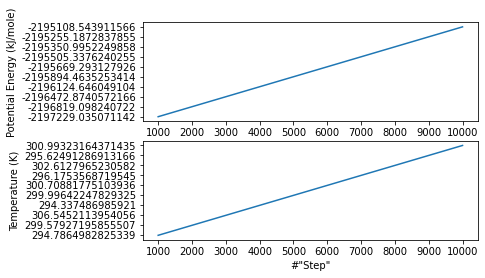

In [26]:
import matplotlib.pyplot as plt
import csv

with open('equilibration_state_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    
    headers = next(plots)
    data = list(zip(*plots))
    
    plt.figure()
    
    for header_idx in range(1, len(headers)):
        plt.subplot(len(headers)-1, 1, header_idx)
        plt.xlabel(headers[0])
        plt.ylabel(headers[header_idx])
        plt.plot(data[0], data[header_idx])

In [7]:
# Load sample peptide
pdb = PDBFile('aaa.pdb')

# Create AMBER forcefield
forcefield = ForceField(
    'amber14-all.xml',
    'amber14/tip3pfb.xml'
)

# Create AMBER system
mm_system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=PME,
    nonbondedCutoff=1*nanometer,
    constraints=HBonds
)

# Select protein atoms to be simulated by ANI2x
ml_atoms  = [atom.index for atom in pdb.topology.atoms() if atom.residue.name == "ALA"]

# Create ANI2x potential
potential = MLPotential('ani2x')

# Create mixed ANI/AMBER system
ml_system = potential.createMixedSystem(pdb.topology, mm_system, ml_atoms)

# Create constant temp integrator
integrator = LangevinMiddleIntegrator(
    300*kelvin,
    1/femtosecond,
    0.004*femtoseconds
)

# Create simulation and set initial positions
simulation = Simulation(
    pdb.topology,
    ml_system,
    integrator
)

simulation.context.setPositions(pdb.positions)

# Local energy minimisation before ANI
simulation.minimizeEnergy()

# Create reporters for output
simulation.reporters.append(
    PDBReporter('output.pdb', 1000)
)
simulation.reporters.append(
    StateDataReporter(
        stdout, 
        1000, 
        step=True,
        potentialEnergy=True, 
        temperature=True
    )
)

FileNotFoundError: ignored

In [ ]:
# Run the simulation through 10000 time steps
simulation.step(10000)